# Manuscript Utils
This notebook contains useful functions for generating figures in the paper.

In [149]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
from typing import Tuple

import sys
sys.path.append("../../python_src/")
from figures_utils import generate_experimental_df

# Global Variables and Replacement Dictionaries

In [163]:
name_replace_dict = {
    "biobakery3": "bioBakery3",
    "biobakery4": "bioBakery4",
    "jams": "JAMS",
    "wgsa2": "WGSA2",
    "wgsa": "WGSA2",
    "woltka": "Woltka",
    "wol": "Woltka",
}

## Expected Plotting
Stacked bar plots with tabulated relative abundances.

In [ ]:
def get_all_expected(root_dir: str, rank="Genus") -> pd.DataFrame:
    combined_expected = pd.DataFrame()
    for root, dirs, files in os.walk(root_dir):
        for f in files:
            # print("files: ", files)
            if f"expected_{rank.lower()}_annotated" in f and f.endswith(".csv"):
                # print(root, f)
                df = pd.read_csv(os.path.join(root, f), index_col=0, names=[rank, 'RA', "TAX_ID"], header=0)
                df["Source"] = root.split("/")[-1]

                # Files are of s#_expected.csv, so we can split on the underscore and take the first part.
                df["SampleID"] = f.split("_")[0]

                # Pipeline for easier grouping later.
                df['Pipeline'] = "Expected"

                combined_expected = pd.concat([combined_expected, df], axis=0)

    return combined_expected

def get_all_relabund_files(root_dir: str, rank="genus") -> pd.DataFrame:
    """
    Parameters:
        root_dir: str 
            The root directory to search for relabund files.
        rank: str
            The taxonomic rank to search for. Default is "genus".
    Returns:
        relabund_files: pd.DataFrame

    Traverses the BASE ROOT directory and searches for ALL {rank}_relabund_annotated files. These are concatenated. \\
    Then, it then returns a dataframe with the sample ID and the path to the relabund file.
    """
    combined_df = pd.DataFrame()
    for root, dirs, files in os.walk(root_dir):
        for f in files:
            if f"{rank.lower()}_relabund_annotated" in f and f.endswith(".csv"):
                # print(root, f)
                p = os.path.join(root, f)
                exp = generate_experimental_df(p, rank)
                exp["Pipeline"] = os.path.dirname(p).split('/')[-1]

                # Add a column to the experimental dataframe with the pipeline name.
                exp['Source'] = os.path.dirname(p).split('/')[-2]

                # Add sampleID to the experimental dataframe.
                exp['SampleID'] = os.path.basename(p).split('_')[0]
                # display(exp.head(10))

                # Add the experimental dataframe to the combined dataframe.
                combined_df = pd.concat([combined_df, exp], axis=0)

    # Ensure that the RA column is a float.
    combined_df['RA'] = combined_df['RA'].astype(float)

    return combined_df

# expected = get_all_expected("../../pipelines/", rank="Genus")
# display(expected.head(50))
# # Print the number of occurences in Source
# expected["Source"].value_counts()

In [ ]:
def plot_pies(expected: pd.DataFrame):
    for source, source_df in expected.groupby("Source"):
        for sample, sample_df in source_df.groupby("SampleID"):
            plot_df = sample_df.loc[sample_df["RA"] > 0]

            plot_df[["RA"]].T.plot(kind="barh", stacked=True, figsize=(20, 10))
            plt.show()

            plt.pie(plot_df["RA"], labels=plot_df.index, autopct='%1.1f%%')
            plt.show()

            # sns.barplot(x='SampleID', y='RA', hue="Genus", data=plot_df)
            # plt.show()

## Creation of comparative stacked bar plots or heatmaps.

We want to create a figure that summarizes the relative abundances of the expected with comparison to each pipeline.

In [182]:
def get_legend_and_add_entry(ax: plt.Axes, color: str, label: str):
    """
    Parameters:
        ax: plt.Axes
            The axes to add the legend entry to.
        color: str
            The color of the legend entry.
        label: str
            The label of the legend entry.
    Returns:
        ax: plt.Axes
            The axes with the legend entry added.
    Gets the legend from the axes and adds a new entry to it. \\
    """
    # Get the legend from the axes.
    handles, labels = ax.get_legend_handles_labels()

    # Add the new legend entry.
    handles.append(mpatches.Patch(color=color, label=label))

    # Set the legend.
    ax.legend(handles=handles, loc="center left", bbox_to_anchor=(1, -0.3), fontsize=16)

    return ax

In [151]:
def fill_df(df: pd.DataFrame, src: str, sampleID: str, rank: str, row_name: str = "Unclassified") -> Tuple[pd.DataFrame, bool]:
    """
    Parameters:
        df: pd.DataFrame
            The dataframe to fill.
        src: str
            The source of the dataframe.
        sampleID: str
            The sampleID of the dataframe.
        rank: str
            The taxonomic rank of the dataframe.
        row_name: str
            The name of the row which will fill. Default is "Unclassified".
    Returns:
        df: pd.DataFrame
            The dataframe with the row filled.
        filled: bool
            Whether or not the row was filled.
    
    Fills the input dataframe in the RA column up to 100% with a row of the input row_name. \\
    """
    # We need to get the sum of the RA column for the dataframe.
    # If it it less than 1, we need to fill the difference with a row called "Unclassified".
    df.reset_index(inplace=True)

    # Get the sum of the RA column.
    sum_ra = df["RA"].sum()
    diff = 1 - sum_ra

    # If the difference is less than zero, we do not need to add anything.
    if diff <= 0:
        df.set_index(rank, inplace=True)
        return df, False

    # Rename index to rank.
    df.index.names = [rank]

    # If the difference is greater than 0, we need to add a row.
    # new_row = pd.DataFrame({rank: "Unclassified", "RA": diff, "TAX_ID": "Unclassified", "Source": src, "SampleID": sampleID, "Pipeline": "wgsa2"}, index=[0])
    new_row = pd.DataFrame({rank: row_name, "RA": diff}, index=[0])
    df = pd.concat([df, new_row], axis=0)

    print(df["RA"].sum())

    df.set_index(rank, inplace=True)

    return df, True

In [184]:
def plots_no_join():
    expected = get_all_expected("../../pipelines/", rank="Genus")
    observed = get_all_relabund_files("../../pipelines/", rank="genus")
    for src, src_df in observed.groupby("Source"):
        if src == "bmock12" or src == "camisimGI":
            print("source: ", src)
            for smpl, smpl_df in src_df.groupby("SampleID"):
            # fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(20, 10))
            # fig.suptitle(f"Relative Abundances between Observed and Expected for {src} {smpl}", fontsize=16, y=0.95)
            # ax_c = 0
                pass
                # grouped_expected = expected.loc[(expected["Source"] == src) & (expected["SampleID"] == smpl)]
                # # grouped_expected[["RA"]].T.plot.barh(stacked=True, ax=ax[0], alpha=0.5, legend=False)

                # plot_df = pd.concat([smpl_df, grouped_expected], axis=0)

                # for pl, pl_df in plot_df.groupby("Pipeline"):
                #     if pl == "wgsa2" or pl == "wgsa":
                #         pl_df = fill_wgsa(pl_df, src, smpl, "Genus")

                #     # display(pl_df.head(10))
                #     T = pl_df[["RA"]].T
                #     # Change the index to the pipeline name.
                #     T.index = [pl]

                #     # display(T.head(10))

                #     ax[ax_c].set_xlim(0, 1.01)
                #     T.plot.barh(alpha=0.5, ax=ax[ax_c], legend=False, stacked=True)
                #     # ax[ax_c].set_title(f"{src} {smpl} {pl}")
                #     ax_c += 1
        else:
            # These are the replicates.
            # Get the expected that matches the source. Since these are replicates, the sampleID doesn't matter.
            groups = src_df.groupby("Pipeline")

            fig, ax = plt.subplots(nrows=len(groups)+1, ncols=1, figsize=(20, 10))
            fig.suptitle(f"Average Relative Abundances between Observed and Expected for {src}", fontsize=16, y=0.95)
            ax_c = 1

            grouped_expected = expected.loc[(expected["Source"] == src)]
            grouped_expected[["RA"]].T.plot.barh(stacked=True, ax=ax[0], alpha=0.5, legend=False)
            ax[0].set_xlim(0, 1.01)

            for pl, pl_df in groups:
                # We want to average all of the replicates. This is where the index values are the same.
                # Get the average of the relabund values.
                avg_df = pl_df[['RA']].groupby("genus").mean()

                if pl == "wgsa2" or pl == "wgsa":
                    avg_df = fill_df(avg_df, src, smpl, "genus")

                # Transpose for plotting.
                T = avg_df.T

                # Change the index to the pipeline name.
                T.index = [pl]

                ax[ax_c].set_xlim(0, 1.01)
                T.plot.barh(alpha=0.5, legend=False, stacked=True, ax=ax[ax_c], fontsize=16)

                ax_c += 1


            plt.show()


    # display(expected.head(10))
    # display(observed.head(10))

In [160]:
def fix_bar_color(ax: plt.Axes):
    """
    Changes the last bar in the ax to be black. \\
    This is done because the legend entry "False Positive" is black and the last bar needs to match.
    """
    children = ax.get_children()

    filtered = filter(lambda x: isinstance(x, matplotlib.patches.Rectangle), children)
    list(filtered)[-2].set_facecolor("black")

1.0
1.0000000000000002
1.0000000000000002
0.9999999999999999


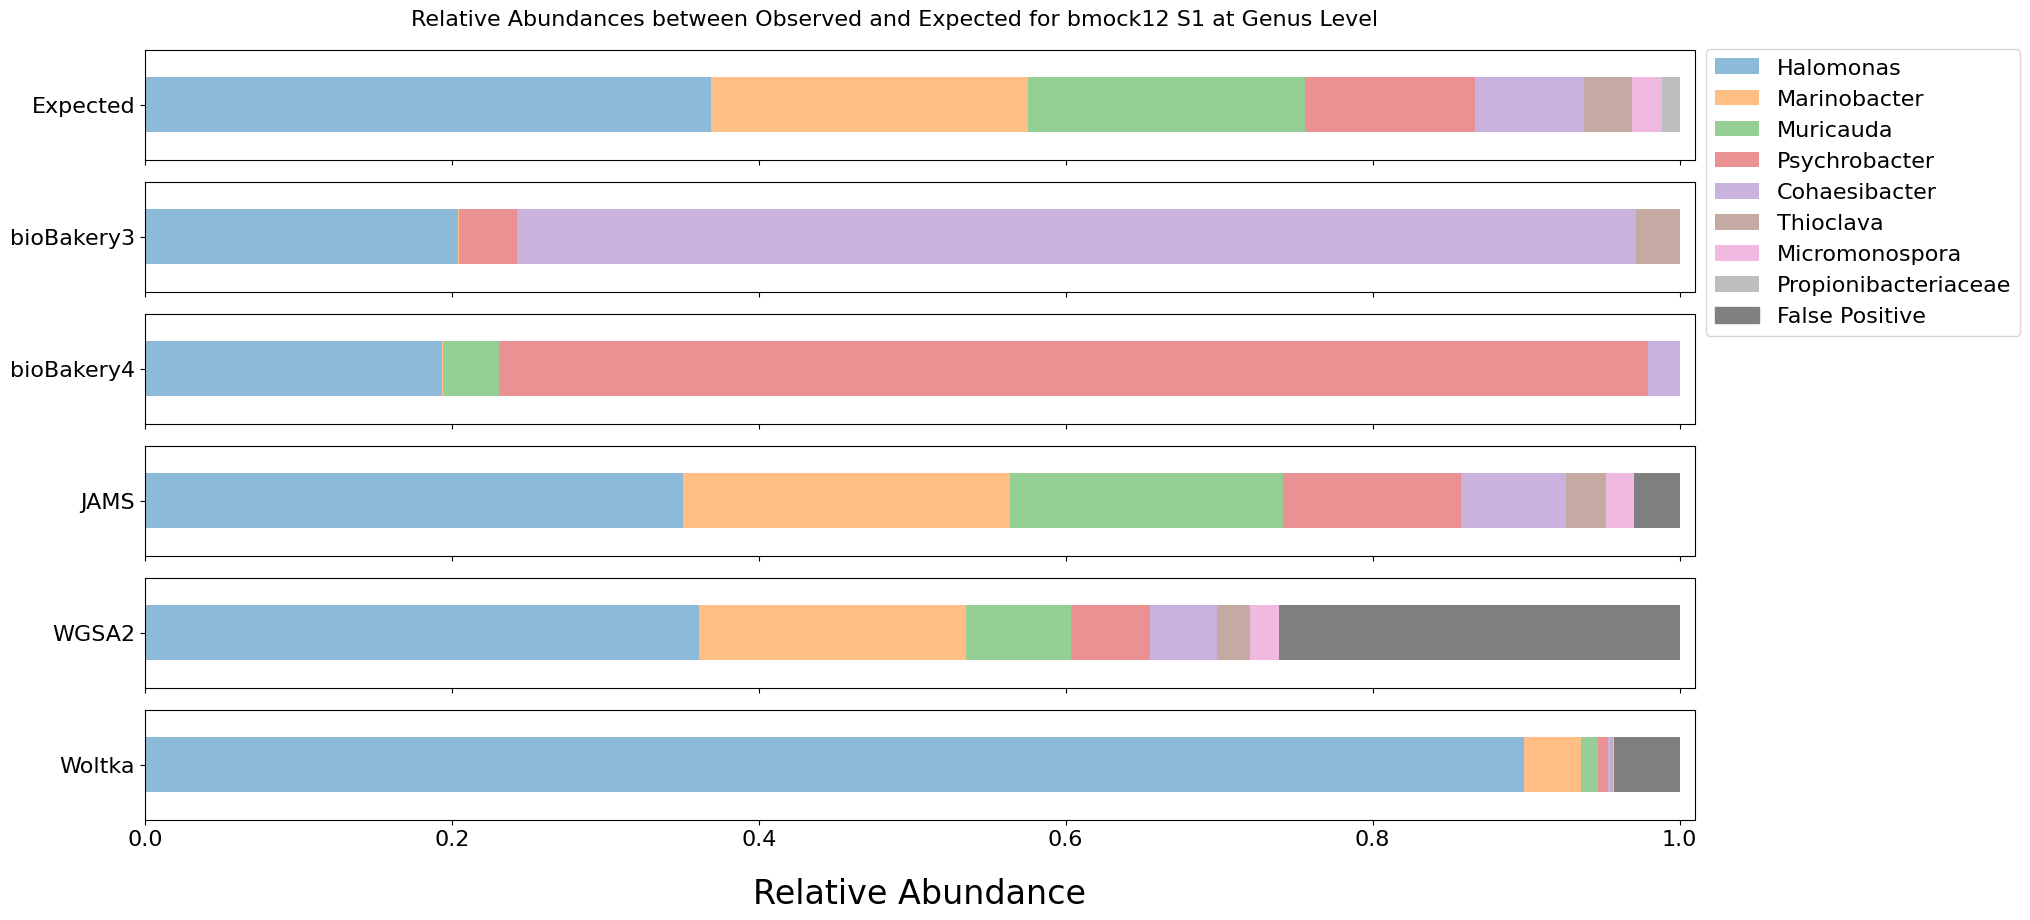

ZeroDivisionError: division by zero

In [191]:
# Now, we want the charts to represent the left join of the expected and observed dataframes.
# This is to reduce the number of taxa.
def stacked_left_join(rank: str):
    expected = get_all_expected("../../pipelines/", rank=rank)
    observed = get_all_relabund_files("../../pipelines/", rank=rank)

    for src, src_df in observed.groupby("Source"):
        if src == "bmock12" or src == "camisimGI":
            groups = src_df.groupby("SampleID")
            for smpl, smpl_df in groups:
                n_rows = len(smpl_df["Pipeline"].unique()) + 1

                fig, ax = plt.subplots(nrows=n_rows, ncols=1, figsize=(20, 10), sharex=True)
                fig.suptitle(f"Relative Abundances between Observed and Expected for {src} {smpl} at {rank.capitalize()} Level", fontsize=16, y=0.92)
                
                ax_c = 1

                grouped_expected = expected.loc[(expected["Source"] == src) & (expected["SampleID"] == smpl)]
                group_T = grouped_expected[["RA"]].T
                group_T.index = ["Expected"]
                group_T.plot.barh(stacked=True, ax=ax[0], alpha=0.5, legend=True, fontsize=16)

                ax[0].set_xlim(0, 1.01)

                ax[0] = get_legend_and_add_entry(ax[0], "grey", "False Positive")
                # ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

                # Get the TAX_ID values from the expected as a set.
                expected_tax_ids_set = set(grouped_expected["TAX_ID"].values)

                # Select the rows from the observed that are in the expected set.
                smpl_df = smpl_df.loc[smpl_df["TAX_ID"].isin(expected_tax_ids_set)]

                for pl, pl_df in smpl_df.groupby("Pipeline"):
                    pl_df, filled = fill_df(pl_df, src, smpl, rank, "False Positive")
                    # display(pl_df.head(10))
                    T = pl_df[["RA"]].T
                    # Change the index to the pipeline name.
                    T.index = [name_replace_dict[pl]]

                    ax[ax_c].set_xlim(0, 1.01)
                    T.plot.barh(alpha=0.5, ax=ax[ax_c], legend=False, stacked=True, fontsize=16)

                    if filled:
                        fix_bar_color(ax[ax_c])
                    
                    ax[ax_c].set_xlabel("Relative Abundance", fontsize=24, labelpad=20)
                        
                    ax_c += 1

                plt.show()

                0 / 0

stacked_left_join("genus")